# Non-Cartesian SENSE reconstruction

Author: Jon Tamir <jtamir@eecs.berkeley.edu>

In this tutorial we build a non-Cartesian SENSE reconstruction, called `sense_recon`, using the BART C API. We use the BART C libraries to implement the SENSE model and run the Conjugate Gradient algorithm. 

To compile the program, the BART toolbox should first be compiled and the `TOOLBOX_PATH` environment variable should point to it.

We will also use the `view` program to plot data and images. It should be included in the `PATH` environment variable


#### For more information, see the following papers:

Pruessmann KP, Weiger M, Scheidegger MB, Boesiger P. SENSE: Sensitivity encoding for fast MRI. Magn Reson Med 1999; 42:952-962.

Pruessmann KP, Weiger M, Boernert P, Boesiger P. Advances in sensitivity encoding with arbitrary k-space trajectories. Magn Reson Med 2001; 46:638-651.


### Requirements
- Install bart (version 0.4.04 or newer): https://github.com/mrirecon/bart  
- Set TOOLBOX_PATH
- Add view program to PATH
```bash
export TOOLBOX_PATH=/path/to/bart  
export PATH=/path/to/view:$PATH
```

Before getting started, let's make a helper function for displaying images. We will use the BART command `toimg`, which can convert BART files to pngs. If our session supports X-windows forwarding, we can instead use the BART viewer, `view`, to open an interactive viewer

In [10]:
function imshow () {
    bart toimg -W $1 $1.png
    cat $1.png | display
    rm $1.png
}

## Source code
The source code to the `sense_recon` tool can be found under `src/sense_recon.c`. Let's look at a few snippets:

#### We include BART modules for different functionality, including numerical operations, iterative optimization, NUFFT, linear operators, file I/O, and more

In [1]:
sed -n '5,21p' < src/sense_recon.c

#include "num/multind.h"
#include "num/init.h"
#include "num/flpmath.h"

#include "iter/iter.h"

#include "noncart/nufft.h"

#include "linops/linop.h"

#include "sense/model.h"

#include "misc/mmio.h"
#include "misc/misc.h"
#include "misc/opts.h"
#include "misc/debug.h"
#include "misc/mri.h"


#### The function `sense_nc_init` creates a non-Cartesian SENSE linear operator, that we will use for our forward model
It takes the sensitivity maps, kspace data, trajectory, and their dimensions, and returns a linear operator

In [2]:
sed -n '34,38p' < src/sense_recon.c

/* 
 * Returns a non-Cartesian SENSE forward model linear operator, consisting of sensitivity map operator
 * and NUFFT operator.
 */
static const struct linop_s* sense_nc_init(const long sens_dims[DIMS], const complex float* sens, const long ksp_dims[DIMS], const long traj_dims[DIMS], const complex float* traj, struct nufft_conf_s conf)


#### The `main` function creates an instance of the forward model linop, computes the linop adjoint of the data, and solves the reconstruction using the conjugate gradient algorithm

In [3]:
sed -n '162p' < src/sense_recon.c
sed -n '170p' < src/sense_recon.c
sed -n '171p' < src/sense_recon.c

	const struct linop_s* forward_op = sense_nc_init(sens_dims, sens, ksp_dims, traj_dims, traj, nuconf);
	complex float* adj = md_alloc(DIMS, img_dims, CFL_SIZE);
	linop_adjoint(forward_op, DIMS, img_dims, adj, DIMS, ksp_dims, ksp);


## Compile the source code
We can compile the program by setting the `TOOLBOX_PATH` to the location of the bart directory. The included `Makefile` will source the necessary BART libraries and compile the program.

In [6]:
export CC=gcc
make
ls | grep sense_recon

gcc-mp-6 -Wall -O2 -std=c11 -fopenmp -Wl,-export_dynamic -o sense_recon src/sense_recon.c -I/Users/jtamir/dev/bart_git/src/ -L/Users/jtamir/dev/bart_git/lib/ -liter -lnoncart -llinops -lsense -lnum -lmisc -lm -lfftw3f -lfftw3f_threads -lopenblas  -lm 
ld: library not found for -lfftw3f
collect2: error: ld returned 1 exit status
make: *** [sense_recon] Error 1


: 1

Print the help message of the program

In [5]:
./sense_recon -h

Usage: ./sense_recon [-i d] [-r f] <trajectory> <rawdata> <sens> <img>

Perform non-Cartesian CG-SENSE reconstruction with l2 regularization.

-i itr      	maximum number of iterations
-r lambda      	l2 regularization parameter
-h		help


## Unpack the data

We will use the brain data provided for the ISMRM 2019 reproducibility challenge, available at 
https://blog.ismrm.org/2019/04/02/ismrm-reproducible-research-study-group-2019-reproduce-a-seminal-paper-initiative. We have converted the data into the BART cfl/hdr format

In [6]:
pushd data
tar -xvvf data.tgz
popd

DIRSTACK: ~/projects/bart-workshop/demos/sense-recon/data ~/projects/bart-workshop/demos/sense-recon
-rw------- jtamir/jtamir 8640000 2019-04-29 18:42 sens.cfl
-rw------- jtamir/jtamir     169 2019-04-29 18:42 sens.hdr
-rw-rw-r-- jtamir/jtamir 4718592 2019-04-29 18:46 rawdata.cfl
-rw-rw-r-- jtamir/jtamir      26 2019-04-29 18:46 rawdata.hdr
-rw-rw-r-- jtamir/jtamir 1179648 2019-04-29 18:46 trajectory.cfl
-rw-rw-r-- jtamir/jtamir      23 2019-04-29 18:46 trajectory.hdr
DIRSTACK: ~/projects/bart-workshop/demos/sense-recon


Raw Data
Writing 1 image(s)...done.


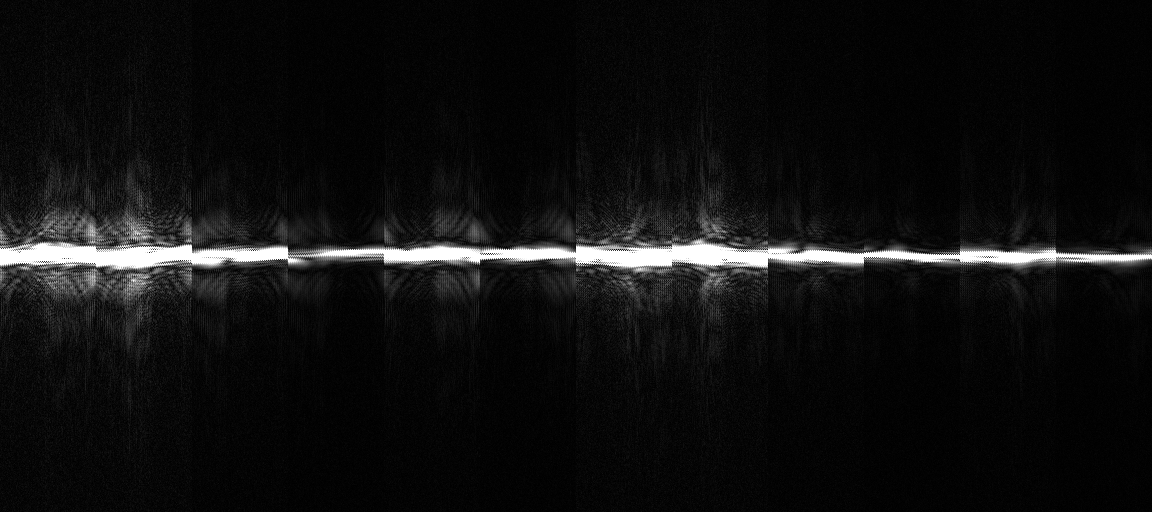

Coil sensitivity maps
Writing 1 image(s)...done.


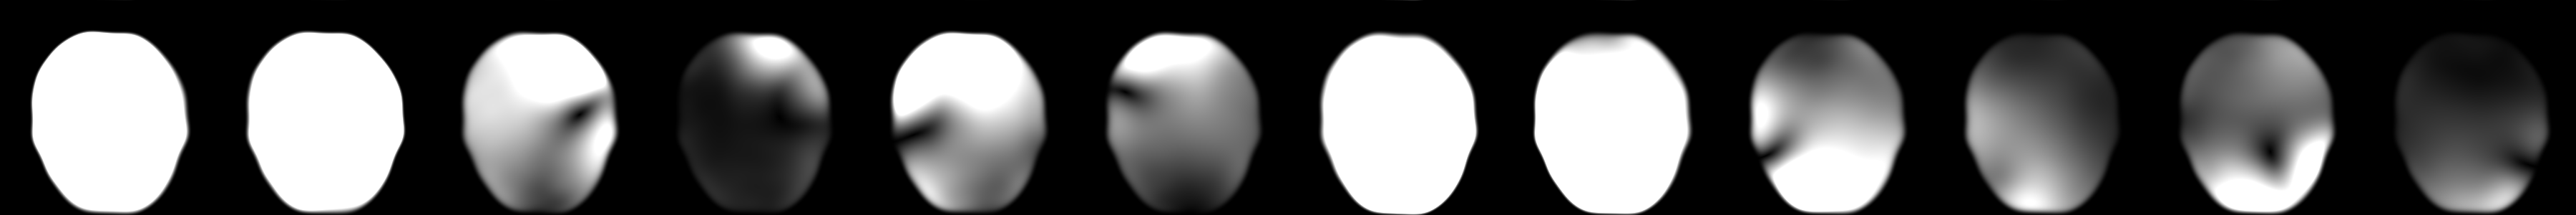

In [17]:
# reshape rawdata and sensitivity maps for image display
echo "Raw Data"
bart reshape `bart bitmask 2 3` 1152 1 data/rawdata data/rawdata_flat
imshow data/rawdata_flat

echo "Coil sensitivity maps"
bart reshape `bart bitmask 1 3` 3600 1 data/sens data/sens_flat
imshow data/sens_flat

#view data/rawdata &
# view data/sens &

Non-Cartesian CG-SENSE Reconstruction
ksp : [  1 512  96  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: low-mem mode
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
#0: 1.212388
	 cg:   1
Writing 1 image(s)...done.


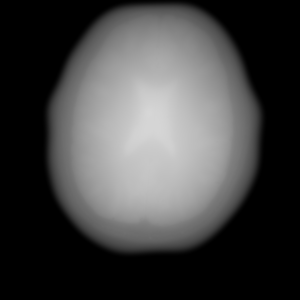

In [38]:
# first do a sense reconstruction with only 1 iteration, similar to the adjoint
./sense_recon -i 1 -r .2 data/trajectory data/rawdata data/sens reco
bart flip 1 reco reco1
imshow reco1

Non-Cartesian CG-SENSE Reconstruction
ksp : [  1 512  96  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [300 300   1  12   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
ksp : [  1 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [600 600   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 512  96   1   1   1   1   1   1   1   1   1   1   1   1   1   1 ]
NUFFT: low-mem mode
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
Linking args 1-2 of 4.
#0: 1.212388
#1: 0.110693
#2: 0.032519
#3: 0.023002
#4: 0.012807
#5: 0.009070
#6: 0.006068
#7: 0.004484
#8: 0.002890
#9: 0.002631
#10: 0.003026
#11: 0.001516
#12: 0.001194
#13: 0.000842
#14: 0.000641
#15: 0.000534
#16: 0.000519
#17: 0.000567
#18: 0.000462
#19: 0.000409
	 cg:  20
Reconstruction
Writing 1 image(s)...done.


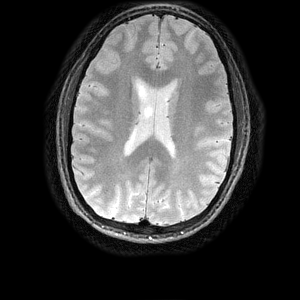

In [37]:
# now run more iterations
./sense_recon -i20 -r .2 data/trajectory data/rawdata data/sens reco

bart flip 1 reco reco1
echo "Reconstruction"
imshow reco1